In [2]:
# Importing the required libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import hvplot
import hvplot.pandas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pathlib import Path
from pystreamlit import InsiderDataFrame

#Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
stock="MSFT"

In [5]:
#instantiate insider class
insider = InsiderDataFrame("insider_data_v2.csv")

# Instantiate the Insider Class
stock_df = insider.get_processed_df(stock) 

# Droping any null values due to filing date being on a non trading day.
stock_df = stock_df.dropna()

stock_nvda = insider.get_processed_df("NVDA")

stock_nvda


,Price,Qty,Owned,ΔOwn,Value,ClosePrice,Trend
2019-07-01,164.01,-2236.0,239710.0,-1.0,-366733.0,41.316437,0.0
2019-07-16,166.80,-2500.0,20684.0,-11.0,-416997.0,41.542690,0.0
2019-08-21,167.36,-2500.0,18184.0,-12.0,-418388.0,42.574547,0.0
2019-08-26,171.73,-5000.0,31037.0,-14.0,-858671.0,41.137413,0.0
2019-08-28,165.97,-15000.0,18792.0,-44.0,-2489571.0,40.125347,1.0
...,...,...,...,...,...,...,...
2023-06-14,403.17,-119795.0,814330.0,-13.0,-48297293.0,429.970001,0.0
2023-06-15,424.69,-860.0,501438.0,0.0,-365233.0,426.529999,0.0
2023-06-16,422.15,-50000.0,3986962.0,-1.0,-21107720.0,426.920013,0.0
2023-06-21,431.03,-118602.0,4324184.0,-3.0,-51120609.0,430.450012,0.0


In [176]:
def logistic_regression_model(stock_df):
    # Import modules for Logistic Regression
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Create X, or features DataFrame
    features = stock_df[['Price','Qty','Value',"Owned","ΔOwn",'ClosePrice']]

    # Create y, or target DataFrame
    target = stock_df['Trend']

    # Use train_test_split to separate the data
    training_features, testing_features, training_targets, testing_targets = train_test_split(features, target, test_size=.3)


    #Scale the data
    scaler = StandardScaler()
    X_scaler = scaler.fit(training_features)
    training_features_scaled = X_scaler.transform(training_features)
    testing_features_scaled = X_scaler.transform(testing_features)

    #Instantiate a model
    logistic_regression_model = LogisticRegression(max_iter=1000,random_state=7)

    # Fit the model
    logistic_regression_model.fit(training_features_scaled, training_targets)


    # Generate predictions from the model we just fit
    predictions = logistic_regression_model.predict(training_features_scaled)

    # Convert those predictions (and actual values) to a DataFrame
    results_df = pd.DataFrame({"Prediction": predictions, "Actual": training_targets})

    # Apply the fitted model to the test dataset
    testing_predictions = logistic_regression_model.predict(testing_features_scaled)

    # Save both the test predictions and actual test values to a DataFrame
    results_df = pd.DataFrame({
    "Testing Data Predictions": testing_predictions,
    "Testing Data Actual Targets": testing_targets})

    #Print the confusion matrix for training data
    training_matrix = confusion_matrix(training_targets, predictions)
    print("Confusion matrix for training data")
    print(training_matrix)
    # Plot the confusion matrix for Training data
    cmd = ConfusionMatrixDisplay(training_matrix)  
    cmd.plot()

    #Print the confusion matrix for testing data
    testing_matrix = confusion_matrix(testing_targets, testing_predictions)
    print("Confusion matrix for testing data")
    print(testing_matrix)
    # Print the confusion matrix for Testing data
    cmd = ConfusionMatrixDisplay( testing_matrix)  
    cmd.plot()

    # Classification report for training data
    training_report = classification_report(training_targets, predictions)
    # Then view its output
    print("Classification report for training data")
    print(training_report)

    # Classification report for training data
    testing_report = classification_report(testing_targets, testing_predictions)
    # Then view its output
    print("Classification report for testing data")
    print(testing_report)   

Confusion matrix for training data
[[27  0]
 [16  1]]
Confusion matrix for testing data
[[9 1]
 [9 1]]
Classification report for training data
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77        27
         1.0       1.00      0.06      0.11        17

    accuracy                           0.64        44
   macro avg       0.81      0.53      0.44        44
weighted avg       0.77      0.64      0.52        44

Classification report for testing data
              precision    recall  f1-score   support

         0.0       0.50      0.90      0.64        10
         1.0       0.50      0.10      0.17        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.40        20
weighted avg       0.50      0.50      0.40        20



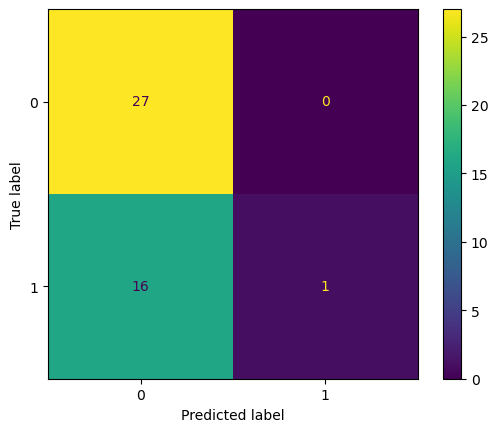

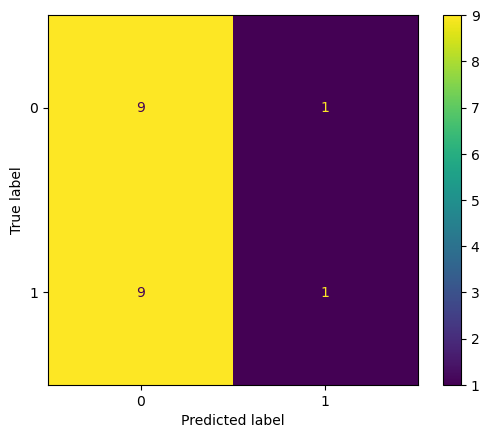

In [177]:
# Calling the Logistic Regression Model
logistic_regression_model(stock_df)

In [7]:

# Create charts for the stocks insider trading.
def create_charts():
    # Create a chart that shows all the insider trades for the stock
    stock_scatter_plot = stock_df.hvplot.scatter(y="Value",title=f"Insider Trades for {stock} by Date", ylabel="Value of Trades",rot=90, cmap="plasma").opts(yformatter='$%.0f')

    # Create a chart that shows the closing price on the insider trading days

    stock_insider_trades_plot = stock_df.hvplot.scatter(y="ClosePrice", color="orange", title=f"{stock} Insider Trades by Price", ylabel="Stock Price",rot=45, width=1000).opts(yformatter='$%.0f')
    
    # Create a chart to show the stock price overtime
    stock_price_df  = insider.df_tickers
    stock_price_df  = stock_price_df[stock].loc[pd.Timestamp(insider.fromdate):pd.Timestamp(insider.todate)]
    stock_price_plot = stock_price_df.hvplot(color="blue", title=f"{stock} Insider Trades and Stock Price", ylabel="Closing Price",rot=45, width=1000).opts(yformatter='$%.0f')

    #Overlay the stock price and the insider trading data
    overlay_stock_Plot = stock_price_plot * stock_insider_trades_plot

    #Display the charts
    display(stock_scatter_plot)
    display(overlay_stock_Plot)
   


In [8]:
# Create the charts for the stocks and trades for the stock
create_charts()

:Scatter   [index]   (Value)

:Overlay
   .Curve.MSFT :Curve   [index]   (MSFT)
   .Scatter.I  :Scatter   [index]   (ClosePrice)